In [56]:
import re
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import pymongo
import json
import pymongo
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
client = pymongo.MongoClient('54.201.199.246', 27016)

wiki_db = client.wikipedia

wiki_col = wiki_db.my_collection

In [92]:
wiki_col.count()

5654

In [93]:
cursor = wiki_col.find()

In [94]:
wiki_df = pd.DataFrame(list(cursor))

In [95]:
wiki_df['article'][4]

'Alteryx'

In [96]:
wiki_df.head()

,_id,article,content,main_cat,page_id,sub_cat
0,5a15de5730b30c01325f0260,Business software,merge enterprise software date october softw...,Business software,1037763,Business software
1,5a15de5830b30c01325f0261,AccuSystems,multiple issue orphan date february notabili...,Business software,41270069,Business software
2,5a15de5830b30c01325f0262,Active policy management,active policy management business orient ent...,Business software,5211212,Business software
3,5a15de5830b30c01325f0263,Alexandria (library software),use alexandria alexandria browser base softw...,Business software,28502793,Business software
4,5a15de5930b30c01325f0264,Alteryx,infobox company name alteryx logo file alter...,Business software,44133735,Business software


In [97]:
tfidf_vectorizer = TfidfVectorizer(min_df = 20, stop_words = 'english')

article_term_matrix_sps = tfidf_vectorizer.fit_transform(wiki_df.content)

article_term_matrix_df = pd.DataFrame(article_term_matrix_sps.toarray(),
                                       index=wiki_df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

In [98]:
article_term_matrix_df.shape


(5654, 6367)

In [72]:
pd.concat([wiki_df.article, wiki_df.content, article_term_matrix_df], axis=1).sample(4)

,article,content,aa,aaa,aaai,aaron,ab,abandon,abbr,abbrev,...,zhou,zimbra,zip,zoho,zone,zoo,zoom,zope,zurich,zx
1413,EntireX,refimprove date august entirex dcom commerci...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
529,Tycoon City: New York,infobox video game title tycoon city new yor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4330,Keras,infobox software name kera logo file kera lo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3629,Springpad,infobox website name springpad logo screensh...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
n_components = 25
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [78]:
svd_matrix = SVD.fit_transform(article_term_matrix_df)

In [79]:
sum(SVD.explained_variance_ratio_)

0.18061032458890552

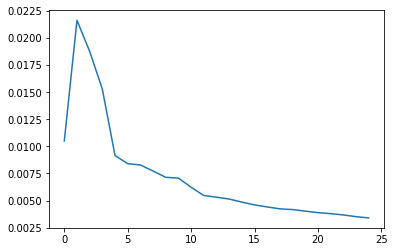

In [80]:
plt.plot(SVD.explained_variance_ratio_)

In [61]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                        index=article_term_matrix_df.index,
                                        columns=component_names)
latent_semantic_analysis['content'] = wiki_df.content
latent_semantic_analysis['article'] = wiki_df.article

vocabulary_expression = pd.DataFrame(SVD.components_,
                                     index=component_names,
                                     columns=tfidf_vectorizer.get_feature_names()).T

In [62]:
for i in range(1,11):
    vocabulary_expression['abs_component_{}'.format(i)] = \
    np.abs(vocabulary_expression['component_{}'.format(i)])

In [63]:
vocabulary_expression.head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,abs_component_1,abs_component_2,abs_component_3,abs_component_4,abs_component_5,abs_component_6,abs_component_7,abs_component_8,abs_component_9,abs_component_10
aa,0.000693,0.000029,0.000736,0.000303,0.000499,-0.001310,-0.001095,0.000305,-0.001575,0.001189,...,0.000693,0.000029,0.000736,0.000303,0.000499,0.001310,0.001095,0.000305,0.001575,0.001189
aaai,0.001995,0.001196,0.007201,0.002269,0.002316,0.005222,-0.002294,0.008625,0.002817,-0.000059,...,0.001995,0.001196,0.007201,0.002269,0.002316,0.005222,0.002294,0.008625,0.002817,0.000059
ab,0.002408,-0.000270,0.000955,0.003497,-0.000665,-0.002633,-0.000577,0.000793,0.000074,-0.001750,...,0.002408,0.000270,0.000955,0.003497,0.000665,0.002633,0.000577,0.000793,0.000074,0.001750
abandon,0.002084,0.001059,0.000111,-0.001929,0.001327,0.000614,-0.001386,0.001428,0.002129,0.002568,...,0.002084,0.001059,0.000111,0.001929,0.001327,0.000614,0.001386,0.001428,0.002129,0.002568
abbreviate,0.001245,0.001006,0.000712,-0.000245,0.000585,-0.000010,0.000034,-0.001849,-0.000800,0.003032,...,0.001245,0.001006,0.000712,0.000245,0.000585,0.000010,0.000034,0.001849,0.000800,0.003032
abbreviation,0.001465,0.000058,0.001689,-0.000033,0.002777,0.000904,0.001212,0.002320,-0.000369,0.000596,...,0.001465,0.000058,0.001689,0.000033,0.002777,0.000904,0.001212,0.002320,0.000369,0.000596
ability,0.013607,0.005616,0.005459,-0.004576,0.006147,-0.007347,-0.008283,-0.018065,-0.014822,0.015807,...,0.013607,0.005616,0.005459,0.004576,0.006147,0.007347,0.008283,0.018065,0.014822,0.015807
able,0.009827,0.006418,0.007358,-0.000741,0.002522,-0.005049,0.002191,-0.007890,-0.005350,0.007128,...,0.009827,0.006418,0.007358,0.000741,0.002522,0.005049,0.002191,0.007890,0.005350,0.007128
abs,0.001723,0.000541,0.006222,0.000207,0.000393,0.002444,0.000052,0.004062,0.002599,0.003015,...,0.001723,0.000541,0.006222,0.000207,0.000393,0.002444,0.000052,0.004062,0.002599,0.003015
absence,0.001012,0.000550,0.001395,0.000454,0.000919,-0.001420,-0.000039,-0.003094,-0.000391,-0.000030,...,0.001012,0.000550,0.001395,0.000454,0.000919,0.001420,0.000039,0.003094,0.000391,0.000030


In [64]:
vocabulary_expression['abs_component_1'].sort_values(ascending=False).head(7)

software      0.327799
category      0.182234
company       0.180900
management    0.180333
com           0.141697
http          0.140977
release       0.131323
Name: abs_component_1, dtype: float64

In [65]:
vocabulary_expression['abs_component_2'].sort_values(ascending=False).head(7)

game          0.821833
player        0.249004
video         0.221489
tycoon        0.166521
simulation    0.160566
software      0.119955
park          0.067495
Name: abs_component_2, dtype: float64

In [66]:
vocabulary_expression['abs_component_3'].sort_values(ascending=False).head(7)

network      0.245513
neural       0.241199
algorithm    0.224955
learn        0.213587
model        0.186161
company      0.172579
software     0.172524
Name: abs_component_3, dtype: float64

In [67]:
vocabulary_expression['abs_component_4'].sort_values(ascending=False).head(7)

company     0.469851
java        0.188240
release     0.175323
language    0.165690
version     0.140341
free        0.137981
apache      0.137744
Name: abs_component_4, dtype: float64

In [69]:
vocabulary_expression['abs_component_5'].sort_values(ascending=False).head(7)

health        0.429385
patient       0.226409
medical       0.225164
ref           0.217327
record        0.211439
java          0.195048
healthcare    0.188276
Name: abs_component_5, dtype: float64